In [23]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

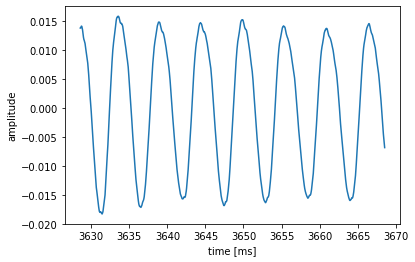

In [24]:
# 音声の読み込み
master, fs = sf.read("audio/JKspeech/J01.wav")

t = np.arange(0, len(master) / fs, 1/fs)

# 音声波形の中心部分（定常部）を切り出す
center = len(master)//2 #　中心のサンプル番号
cuttime = 0.04 # 秒
x = master[int(center - cuttime / 2 * fs):int(center + cuttime / 2 * fs)]
time = t[int(center - cuttime/2*fs): int(center + cuttime/2*fs)]

plt.plot(time * 1000, x)
plt.xlabel("time [ms]")
plt.ylabel("amplitude")
plt.show()

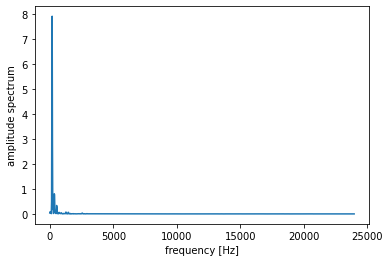

In [25]:
# ハミング窓をかける
hamming = np.hamming(len(x))
x = x * hamming

# 振幅スペクトルを求める
N = 2048 # FFTのサンプル数
spec = np.abs(np.fft.fft(x, N))[:N//2]
fscale = np.fft.fftfreq(N, d = 1.0 / fs)[:N//2]

plt.plot(fscale, spec)
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude spectrum")
plt.show()

[  12.   20.   29.   40.   53.   68.   86.  108.  133.  163.  199.  241.
  291.  351.  421.  505.  604.  721.  860. 1024.]


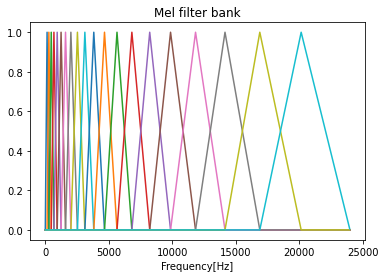

In [26]:
def hz2mel(f):
  """Hzをmelに変換"""
  return 2595 * np.log(f / 700.0 + 1.0)

def mel2hz(m):
  """melをhzに変換"""
  return 700 * (np.exp(m / 2595) - 1.0)

def melFilterBank(fs, N, numChannels):
  """メルフィルタバンクを作成"""
  # ナイキスト周波数（Hz）
  fmax = fs / 2
  # ナイキスト周波数（mel）
  melmax = hz2mel(fmax)
  # 周波数インデックスの最大数
  nmax = N // 2
  # 周波数解像度（周波数インデックス1あたりのHz幅）
  df = fs / N
  # メル尺度における各フィルタの中心周波数を求める
  dmel = melmax / (numChannels + 1)
  melcenters = np.arange(1, numChannels + 1) * dmel
  # 各フィルタの中心周波数をHzに変換
  fcenters = mel2hz(melcenters)
  # 各フィルタの中心周波数を周波数インデックスに変換
  indexcenter = np.round(fcenters / df)
  # 各フィルタの開始位置のインデックス
  indexstart = np.hstack(([0], indexcenter[0:numChannels - 1]))
  # 各フィルタの終了位置のインデックス
  indexstop = np.hstack((indexcenter[1:numChannels], [nmax]))
  filterbank = np.zeros((numChannels, nmax))
  print(indexstop)
  for c in range(0, numChannels):
    # 三角フィルタの左の直線の傾きから点を求める
    increment= 1.0 / (indexcenter[c] - indexstart[c])
    for i in range(int(indexstart[c]), int(indexcenter[c])):
      filterbank[c, i] = (i - indexstart[c]) * increment
    # 三角フィルタの右の直線の傾きから点を求める
    decrement = 1.0 / (indexstop[c] - indexcenter[c])
    for i in range(int(indexcenter[c]), int(indexstop[c])):
      filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)

  return filterbank, fcenters

# メルフィルタバンクを作成
numChannels = 20  # メルフィルタバンクのチャネル数
df = fs / N   # 周波数解像度（周波数インデックス1あたりのHz幅）
filterbank, fcenters = melFilterBank(fs, N, numChannels)

# メルフィルタバンクのプロット
for c in np.arange(0, numChannels):
  plt.plot(np.arange(0, N / 2) * df, filterbank[c])

plt.title('Mel filter bank')
plt.xlabel('Frequency[Hz]')
plt.show()

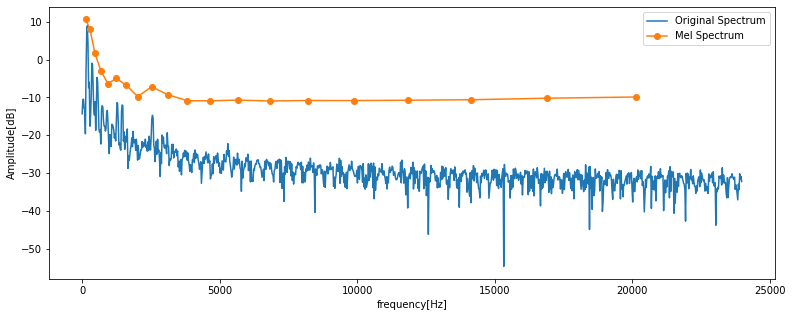

In [27]:
# 振幅スペクトルにメルフィルタバンクを適用
mspec = np.dot(spec, filterbank.T)

# 元の振幅スペクトルとフィルタバンクをかけて圧縮したスペクトルを表示
plt.figure(figsize=(13, 5))

plt.plot(fscale, 10* np.log10(spec), label='Original Spectrum')
plt.plot(fcenters, 10 * np.log10(mspec), "o-", label='Mel Spectrum')
plt.xlabel("frequency[Hz]")
plt.ylabel('Amplitude[dB]')
plt.legend()
plt.show()

In [32]:
from scipy.fftpack import dct
ceps = dct(10 * np.log10(mspec), type=2, norm="ortho", axis=-1)
nceps = 12
mfcc = ceps[:nceps]
print(mfcc)

[-29.83307989  21.15545337  14.08131033   7.18950666   6.14913014
   4.49545471   3.06860852   1.07857897   0.9627552    0.40523547
  -0.86733655  -1.92429914]
